In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
tqdm.pandas()

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Bidirectional, GRU, LSTM, Dense, TimeDistributed
from tf2crf import CRF, ModelWithCRFLoss, ModelWithCRFLossDSCLoss
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

import fasttext
import fasttext.util

from seqeval.metrics import classification_report
from seqeval.metrics import f1_score
# fasttext.util.download_model('en', if_exists='ignore')

2025-02-13 14:24:46.239603: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-13 14:24:46.288305: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-13 14:24:46.288347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-13 14:24:46.289864: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-13 14:24:46.299112: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Load dataset
def load_data(filename):
    sentences, labels = [], []
    sentence, label = [], []
    with open(filename, "r", encoding="utf-8") as file:
        for line in file:
            if line.strip() == "":
                if sentence:
                    sentences.append(sentence)
                    labels.append(label)
                    sentence, label = [], []
            else:
                parts = line.strip().split()
                if len(parts) == 2:
                    word, tag = parts
                    sentence.append(word)
                    label.append(tag)
    return sentences, labels

# File paths
train_file = "/home/jupyter-sigitpurnomo/teaching/nlp/corpus/train-70.txt"
valid_file = "/home/jupyter-sigitpurnomo/teaching/nlp/corpus/dev-30.txt"
test_file = "/home/jupyter-sigitpurnomo/teaching/nlp/corpus/test-data.txt"

# Load datasets
train_sentences, train_labels = load_data(train_file)
valid_sentences, valid_labels = load_data(valid_file)
test_sentences, test_labels = load_data(test_file)



In [3]:
train_df = pd.DataFrame({'tokens': train_sentences, 'tags': train_labels})
valid_df = pd.DataFrame({'tokens': valid_sentences, 'tags': valid_labels})
test_df = pd.DataFrame({'tokens': test_sentences, 'tags': test_labels})

print(train_df.shape, valid_df.shape, test_df.shape)
train_df.head()

(29251, 2) (12557, 2) (5067, 2)


,tokens,tags
0,"[JAKARTA, ,, KOMPAS, —, Perangkat, suar, yang,...","[O, O, O, O, B-ISSUE, I-ISSUE, I-ISSUE, I-ISSU..."
1,"[Namun, ,, Badan, Nasional, Pencarian, dan, Pe...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[Pencarian, titik, lokasi, jatuhnya, pesawat, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[Hal, tersebut, disampaikan, Deputi, Operasi, ...","[O, O, O, B-ROLE, I-ROLE, I-ROLE, I-ROLE, I-RO..."
4,"[Sampai, dengan, Sabtu, pukul, 20.10, ,, Basar...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


Train Max length: 98
Valid Max length: 87
Test Max length: 112


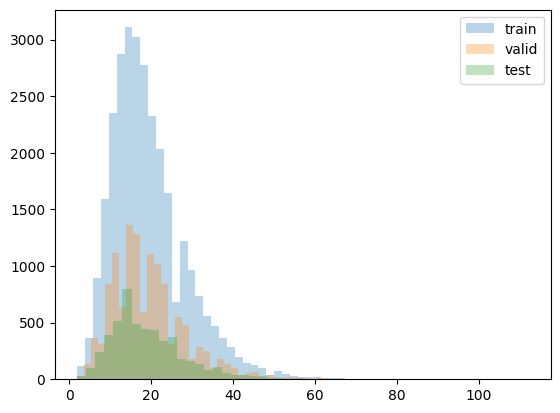

In [4]:
# Length of sequences
train_seq_len = [len(item) for item in train_df['tokens']]
valid_seq_len = [len(item) for item in valid_df['tokens']]
test_seq_len = [len(item) for item in test_df['tokens']]
print(f'Train Max length: {max(train_seq_len)}')
print(f'Valid Max length: {max(valid_seq_len)}')
print(f'Test Max length: {max(test_seq_len)}')
plt.hist(train_seq_len, bins=50, alpha=0.3, label='train')
plt.hist(valid_seq_len, bins=50, alpha=0.3, label='valid')
plt.hist(test_seq_len, bins=50, alpha=0.3, label='test')
plt.legend();

In [5]:
# Load FastText embeddings
# Constants
emb_size = 300
max_seq_len = 50

ft = fasttext.load_model('/home/jupyter-sigitpurnomo/research/peer-code-review/cc.id.300.bin') 


In [6]:
# Convert Tokens to Embedding
def get_tok_emb(tokens): 
    emb = np.zeros((max_seq_len, emb_size))
    
    for i, word in enumerate(tokens[:max_seq_len]):
        emb[i] = ft.get_word_vector(word)
    return emb        
    
train_df['tokens_embedding'] = train_df['tokens'].progress_apply(get_tok_emb)
valid_df['tokens_embedding'] = valid_df['tokens'].progress_apply(get_tok_emb)
test_df['tokens_embedding'] = test_df['tokens'].progress_apply(get_tok_emb)

train_df.head(2)

100%|██████████| 5067/5067 [00:00<00:00, 10237.43it/s]


,tokens,tags,tokens_embedding
0,"[JAKARTA, ,, KOMPAS, —, Perangkat, suar, yang,...","[O, O, O, O, B-ISSUE, I-ISSUE, I-ISSUE, I-ISSU...","[[-0.10371072590351105, -0.005738112144172192,..."
1,"[Namun, ,, Badan, Nasional, Pencarian, dan, Pe...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[[-0.0009020785801112652, -0.03759860619902611..."


In [7]:
# Convert Tags to Indices
all_unique_tags = np.unique([item for tags in train_labels for item in tags])
tag2index = {value:key+1 for key, value in enumerate(all_unique_tags)}
tag2index['B-PAD'] = 0
index2tag = {key:value for value, key in tag2index.items()}

def get_tag_emb(tags):
    emb = np.zeros((max_seq_len), dtype=int)
    
    for i, tag in enumerate(tags[:max_seq_len]):
        emb[i] = tag2index.get(tag)
    return emb 

train_df['tags_embedding'] = train_df['tags'].progress_apply(get_tag_emb)
valid_df['tags_embedding'] = valid_df['tags'].progress_apply(get_tag_emb)
test_df['tags_embedding'] = test_df['tags'].progress_apply(get_tag_emb)
train_df.head(2)



100%|██████████| 5067/5067 [00:00<00:00, 375871.71it/s]


,tokens,tags,tokens_embedding,tags_embedding
0,"[JAKARTA, ,, KOMPAS, —, Perangkat, suar, yang,...","[O, O, O, O, B-ISSUE, I-ISSUE, I-ISSUE, I-ISSU...","[[-0.10371072590351105, -0.005738112144172192,...","[28, 28, 28, 28, 4, 13, 13, 13, 13, 13, 13, 13..."
1,"[Namun, ,, Badan, Nasional, Pencarian, dan, Pe...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[[-0.0009020785801112652, -0.03759860619902611...","[28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 2..."


In [8]:
X_train = train_df['tokens_embedding'].values.tolist()
X_val = valid_df['tokens_embedding'].values.tolist()
y_train = train_df['tags_embedding'].values.tolist()
y_val = valid_df['tags_embedding'].values.tolist()

In [9]:
# Constants
rnn_units = 64
num_tags = len(tag2index)  # Number of output tags
lr = 0.01
rnn_type = "BiGRU"  # Options: "SimpleRNN", "LSTM", "BiLSTM", "BiGRU"

# **Modified Function to Allow Different RNN Architectures**
def rnn_crf(max_len_seq, emb_size, rnn_units, num_tags, lr, rnn_type=rnn_type):
    inputs = Input(shape=(max_len_seq, emb_size), dtype='float32')
    
    # Select RNN Type
    if rnn_type == "SimpleRNN":
        output = SimpleRNN(rnn_units, return_sequences=True)(inputs)
    elif rnn_type == "LSTM":
        output = LSTM(rnn_units, return_sequences=True)(inputs)
    elif rnn_type == "BiLSTM":
        output = Bidirectional(LSTM(rnn_units, return_sequences=True))(inputs)
    elif rnn_type == "BiGRU":
        output = Bidirectional(GRU(rnn_units, return_sequences=True))(inputs)
    else:
        raise ValueError("Invalid rnn_type. Choose from 'SimpleRNN', 'LSTM', 'BiLSTM', 'BiGRU'.")

    output = CRF(units=num_tags, dtype='float32')(output)
    
    base_model = Model(inputs, output)
    model = ModelWithCRFLoss(base_model)
    model.compile(optimizer=Adam(lr))
    
    return model

# Build Model with Selected RNN Type
model = rnn_crf(max_seq_len, emb_size, rnn_units, num_tags, lr, rnn_type)

2025-02-13 14:24:57.666666: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
np.random.seed(55)
tf.random.set_seed(55)

cp_callback = ModelCheckpoint(filepath='/home/jupyter-sigitpurnomo/teaching/nlp/best_model', verbose=1, monitor='val_val_accuracy',
                              mode='max', save_weights_only=False, save_best_only=True)

earlystop = EarlyStopping(monitor='val_val_accuracy', patience=5, verbose=1, mode='max', 
                          baseline=None, restore_best_weights=True)

callbacks = [cp_callback, earlystop]

history = model.fit(x=np.asarray(X_train), y=np.asarray(y_train), 
                    validation_data=(np.asarray(X_val), np.asarray(y_val)), 
                    callbacks=callbacks,
                    epochs=5)

Epoch 1/5


2025-02-13 14:25:03.667856: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_BOOL
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond/output/_105'


915/915 [==============================] - ETA: 0s - loss: 3.8757 - accuracy: 0.9498     
Epoch 1: val_val_accuracy improved from -inf to 0.90600, saving model to /home/jupyter-sigitpurnomo/teaching/nlp/best_model
INFO:tensorflow:Assets written to: /home/jupyter-sigitpurnomo/teaching/nlp/best_model/assets


INFO:tensorflow:Assets written to: /home/jupyter-sigitpurnomo/teaching/nlp/best_model/assets


915/915 [==============================] - 144s 154ms/step - loss: 3.8757 - accuracy: 0.9498 - val_loss_val: 1.4839 - val_val_accuracy: 0.9060
Epoch 2/5
915/915 [==============================] - ETA: 0s - loss: 0.9395 - accuracy: 0.9588  
Epoch 2: val_val_accuracy improved from 0.90600 to 0.96111, saving model to /home/jupyter-sigitpurnomo/teaching/nlp/best_model


INFO:tensorflow:Assets written to: /home/jupyter-sigitpurnomo/teaching/nlp/best_model/assets


INFO:tensorflow:Assets written to: /home/jupyter-sigitpurnomo/teaching/nlp/best_model/assets


915/915 [==============================] - 138s 150ms/step - loss: 0.9395 - accuracy: 0.9588 - val_loss_val: 0.9665 - val_val_accuracy: 0.9611
Epoch 3/5
915/915 [==============================] - ETA: 0s - loss: 0.7215 - accuracy: 0.9619  
Epoch 3: val_val_accuracy did not improve from 0.96111
915/915 [==============================] - 131s 143ms/step - loss: 0.7215 - accuracy: 0.9619 - val_loss_val: 0.9524 - val_val_accuracy: 0.9475
Epoch 4/5
915/915 [==============================] - ETA: 0s - loss: 0.6285 - accuracy: 0.9648  
Epoch 4: val_val_accuracy did not improve from 0.96111
915/915 [==============================] - 131s 143ms/step - loss: 0.6285 - accuracy: 0.9648 - val_loss_val: 0.9863 - val_val_accuracy: 0.9576
Epoch 5/5
915/915 [==============================] - ETA: 0s - loss: 0.5390 - accuracy: 0.9665  
Epoch 5: val_val_accuracy did not improve from 0.96111
915/915 [==============================] - 130s 142ms/step - loss: 0.5390 - accuracy: 0.9665 - val_loss_val: 0.8728

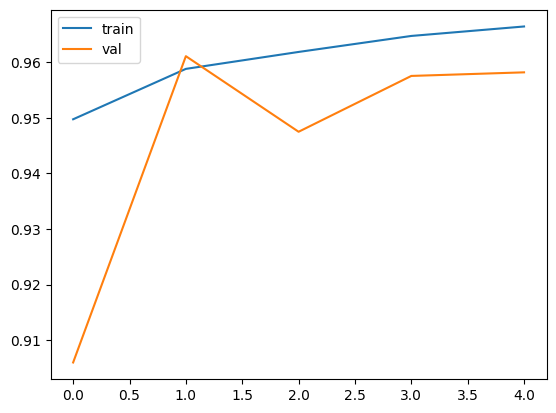

In [11]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_val_accuracy'], label='val')
plt.legend();

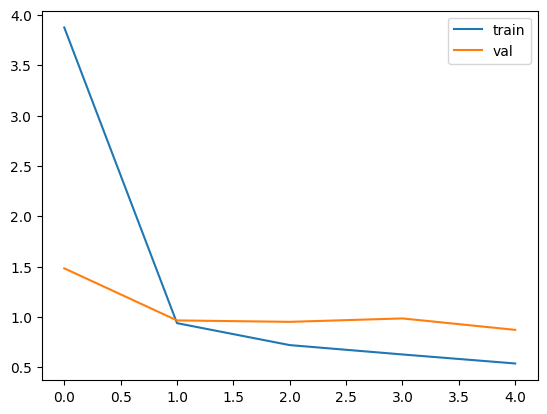

In [12]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss_val'], label='val')
plt.legend();

In [13]:
model = rnn_crf(max_seq_len, emb_size, rnn_units, num_tags, lr, rnn_type)
model.load_weights('/home/jupyter-sigitpurnomo/teaching/nlp/best_model')

2025-02-13 14:36:15.533551: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open /home/jupyter-sigitpurnomo/teaching/nlp/best_model: FAILED_PRECONDITION: /home/jupyter-sigitpurnomo/teaching/nlp/best_model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [14]:
X_test = np.asarray(test_df['tokens_embedding'].values.tolist())
y_test = np.asarray(test_df['tags_embedding'].values.tolist())

predicted_tags = model.predict(X_test)

159/159 [==============================] - 7s 37ms/step


In [15]:
def tag_lookup(row):
    len_tags = len(row['tags'])
    pred_tags_embedding = row['pred_tags_embedding'][:len_tags]
    
    return [index2tag.get(idx, 'O') for idx in pred_tags_embedding]

In [16]:
test_df['pred_tags_embedding'] = predicted_tags.tolist()
test_df['pred_tags'] = test_df.apply(tag_lookup, axis=1)
test_df.head(2)

,tokens,tags,tokens_embedding,tags_embedding,pred_tags_embedding,pred_tags
0,"[JAKARTA, ,, KOMPAS, —, Seorang, perempuan, 34...","[O, O, O, O, B-ISSUE, I-ISSUE, I-ISSUE, I-ISSU...","[[-0.10371072590351105, -0.005738112144172192,...","[28, 28, 28, 28, 4, 13, 13, 13, 13, 13, 13, 13...","[28, 28, 28, 28, 4, 13, 13, 13, 13, 13, 13, 13...","[O, O, O, O, B-ISSUE, I-ISSUE, I-ISSUE, I-ISSU..."
1,"[Sehari, sebelum, meninggal, ,, RCD, mengeluhk...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[[-0.044231660664081573, 0.03410480543971062, ...","[28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 2...","[28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 2...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O]"


In [17]:
y_true = test_df['tags'].values.tolist()
y_pred = test_df['pred_tags'].values.tolist()

print(f"Number of samples in y_true: {len(y_true)}")
print(f"Number of samples in y_pred: {len(y_pred)}")

Number of samples in y_true: 5067
Number of samples in y_pred: 5067


In [18]:
for i, (true_seq, pred_seq) in enumerate(zip(y_true, y_pred)):
    if len(true_seq) != len(pred_seq):
        print(f"Mismatch in sentence {i}: true={len(true_seq)} tokens, pred={len(pred_seq)} tokens")


Mismatch in sentence 371: true=59 tokens, pred=50 tokens
Mismatch in sentence 462: true=56 tokens, pred=50 tokens
Mismatch in sentence 525: true=51 tokens, pred=50 tokens
Mismatch in sentence 843: true=97 tokens, pred=50 tokens
Mismatch in sentence 933: true=52 tokens, pred=50 tokens
Mismatch in sentence 934: true=57 tokens, pred=50 tokens
Mismatch in sentence 1068: true=63 tokens, pred=50 tokens
Mismatch in sentence 1148: true=60 tokens, pred=50 tokens
Mismatch in sentence 1184: true=57 tokens, pred=50 tokens
Mismatch in sentence 1280: true=52 tokens, pred=50 tokens
Mismatch in sentence 1283: true=60 tokens, pred=50 tokens
Mismatch in sentence 1305: true=54 tokens, pred=50 tokens
Mismatch in sentence 1491: true=55 tokens, pred=50 tokens
Mismatch in sentence 1633: true=53 tokens, pred=50 tokens
Mismatch in sentence 1748: true=57 tokens, pred=50 tokens
Mismatch in sentence 1749: true=112 tokens, pred=50 tokens
Mismatch in sentence 1781: true=51 tokens, pred=50 tokens
Mismatch in sentenc

In [19]:
# Pad y_pred sequences to match y_true length
y_pred_fixed = [seq + ["O"] * (len(y_true[i]) - len(seq)) for i, seq in enumerate(y_pred)]


In [20]:
print(f"Overall F1 Score: {f1_score(y_true, y_pred_fixed):.2f}")
print("\nClassification Report")
print(classification_report(y_true, y_pred_fixed, zero_division=0))

/opt/tljh/user/envs/nlp/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: L-ISSUE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/tljh/user/envs/nlp/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: L-ROLE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/tljh/user/envs/nlp/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: L-AFFILIATION seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/tljh/user/envs/nlp/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: L-PERSON seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/tljh/user/envs/nlp/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: L-STATEMENT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.forma

Overall F1 Score: 0.73

Classification Report
              precision    recall  f1-score   support

 AFFILIATION       0.82      0.18      0.29       255
         CUE       0.90      0.89      0.90       351
    CUECOREF       0.89      0.85      0.87       183
    DATETIME       0.86      0.23      0.37        77
       EVENT       0.68      0.39      0.49       106
       ISSUE       0.97      0.89      0.93       140
    LOCATION       0.80      0.60      0.69        40
      PERSON       0.90      0.36      0.51       315
 PERSONCOREF       0.88      0.89      0.88       312
        ROLE       0.59      0.25      0.35       317
   STATEMENT       0.85      0.73      0.79      1583

   micro avg       0.85      0.64      0.73      3679
   macro avg       0.83      0.57      0.64      3679
weighted avg       0.84      0.64      0.70      3679



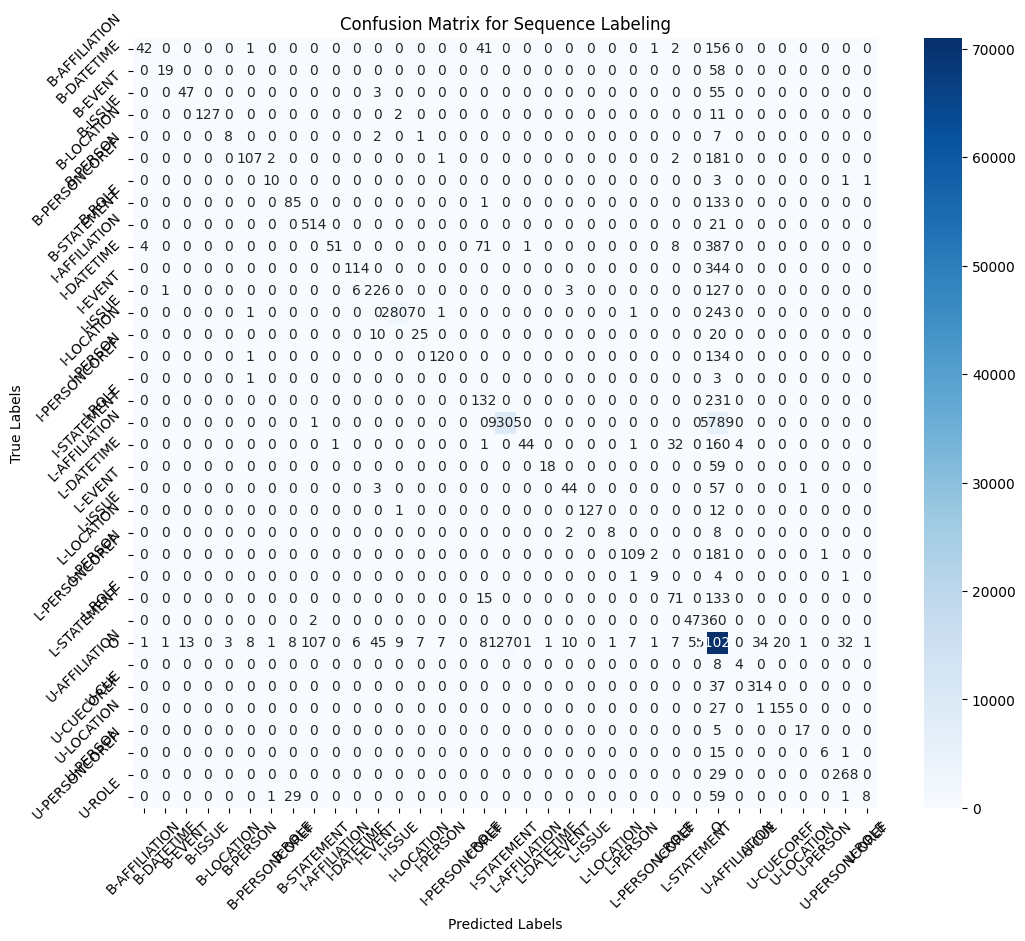

In [21]:
# Get the unique tag labels
labels = sorted(set(tag for seq in y_true for tag in seq))  # Extract unique labels

# Flatten y_true and y_pred for confusion matrix computation
y_true_flat = [tag for seq in y_true for tag in seq]
y_pred_flat = [tag for seq in y_pred_fixed for tag in seq]

# Compute confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Sequence Labeling")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [22]:
def simplify_labels(tag):
    """Removes BIO/BILOU prefixes and returns the main category."""
    return tag.split("-")[-1]  # Keeps only the entity name (e.g., "STATEMENT")

# Apply this function to all labels in y_true and y_pred
y_true_agg = [[simplify_labels(tag) for tag in seq] for seq in y_true]
y_pred_agg = [[simplify_labels(tag) for tag in seq] for seq in y_pred_fixed]

In [23]:
# Flatten lists to prepare for confusion matrix
y_true_flat = [tag for seq in y_true_agg for tag in seq]
y_pred_flat = [tag for seq in y_pred_agg for tag in seq]


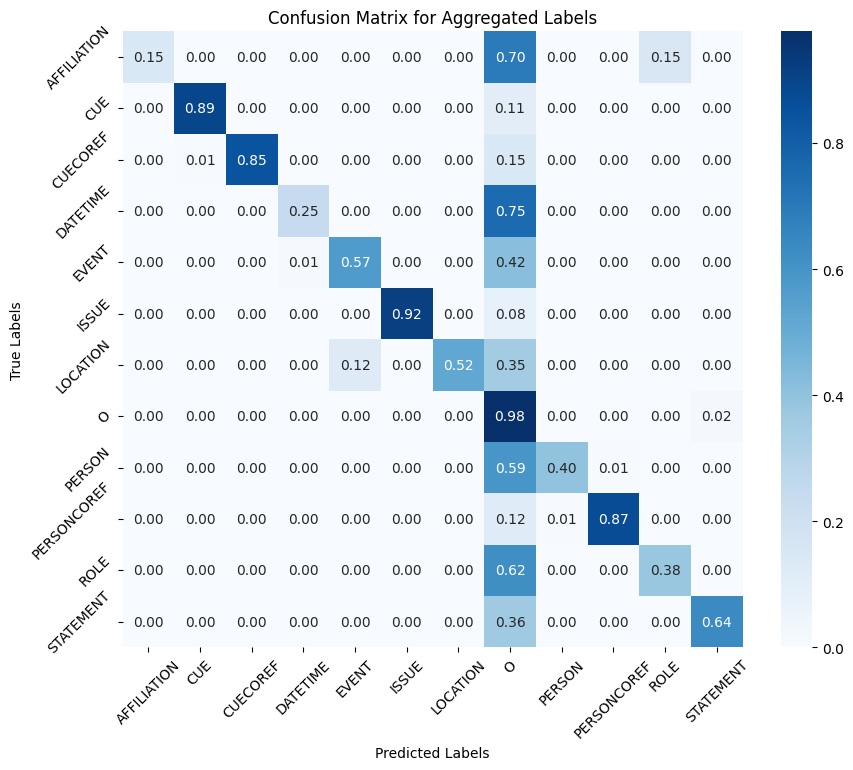

In [24]:
# Get unique aggregated labels
unique_labels = sorted(set(y_true_flat + y_pred_flat))

# Compute confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=unique_labels)

# Normalize the confusion matrix (optional for better visualization)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Aggregated Labels")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [30]:
def print_results(index):
    row = test_df.iloc[index]  # Get row data
    tokens = row['tokens']
    tags = row['tags']
    pred_tags = row['pred_tags']
    
    # Debug prints
    print(f"Index: {index}, Tokens: {tokens}, Tags: {tags}, Pred_Tags: {pred_tags}")
    
    # Ensure they are not empty
    if not tokens or not tags or not pred_tags:
        print("Error: One or more lists are empty.")
        return

    for idx, token in enumerate(tokens):
        print(f'{token} \t Tag -> {tags[idx]} \t Pred_Tag -> {pred_tags[idx]}')

# Test the function
print_results(1)  # Try printing the first row

Index: 1, Tokens: ['Sehari', 'sebelum', 'meninggal', ',', 'RCD', 'mengeluhkan', 'masalah', 'seusai', 'mendapat', 'suntikan', 'filler', 'di', 'payudara', '.'], Tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], Pred_Tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Sehari 	 Tag -> O 	 Pred_Tag -> O
sebelum 	 Tag -> O 	 Pred_Tag -> O
meninggal 	 Tag -> O 	 Pred_Tag -> O
, 	 Tag -> O 	 Pred_Tag -> O
RCD 	 Tag -> O 	 Pred_Tag -> O
mengeluhkan 	 Tag -> O 	 Pred_Tag -> O
masalah 	 Tag -> O 	 Pred_Tag -> O
seusai 	 Tag -> O 	 Pred_Tag -> O
mendapat 	 Tag -> O 	 Pred_Tag -> O
suntikan 	 Tag -> O 	 Pred_Tag -> O
filler 	 Tag -> O 	 Pred_Tag -> O
di 	 Tag -> O 	 Pred_Tag -> O
payudara 	 Tag -> O 	 Pred_Tag -> O
. 	 Tag -> O 	 Pred_Tag -> O
